Loading all libraries necessary to examine the data


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import re



code to receive info as csv and convert it to a pandas data frame

In [18]:
df_games = pd.read_csv("C:\\Users\\King Yair\\PycharmProjects\\ScrabblePorject\\kaggle files\\games.csv")
df_sample_submission = pd.read_csv("C:\\Users\\King Yair\\PycharmProjects\\ScrabblePorject\\kaggle files\\sample_submission.csv")
df_test = pd.read_csv("C:\\Users\\King Yair\\PycharmProjects\\ScrabblePorject\\kaggle files\\test.csv")
df_train = pd.read_csv("C:\\Users\\King Yair\\PycharmProjects\\ScrabblePorject\\kaggle files\\train.csv")
df_turns = pd.read_csv("C:\\Users\\King Yair\\PycharmProjects\\ScrabblePorject\\kaggle files\\turns.csv")

starting to perform eda of the data to search the types of the characteristics

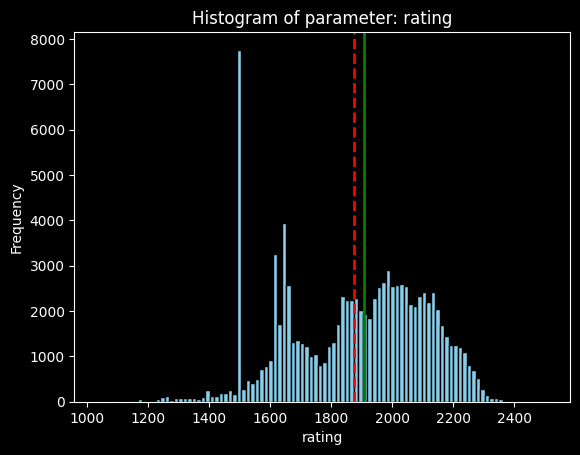

In [56]:
# we go through each data frame and extract only the features that are relevant for us
# EDA for the train data
CURR_FEATURE = "rating"

mean_value = np.mean(df_train[CURR_FEATURE])
median_value = np.median(df_train[CURR_FEATURE])
# Add a vertical line for the mean
plt.hist(df_train[CURR_FEATURE], bins=100, color='skyblue', edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='solid', linewidth=2, label=f'Median: {median_value:.2f}')

# Add labels and a title for clarity
plt.title("Histogram of parameter: " + CURR_FEATURE)
plt.xlabel(CURR_FEATURE)
plt.ylabel("Frequency")

# Display the plot
plt.show()

creating a data table relevant for training - mainly eliminating the correlation between previous games of the player to the result

In [39]:
df_train_output = df_train[["game_id", "nickname", "rating"]]
df_train_input = df_train.merge(df_turns, how="left", on="game_id").drop("rating", axis=1)
df_train_input = df_train_input.merge(df_games, how="left", on="game_id")
df_train_input.head()
# perform analyzing over the data in order to extract more knowledge
# removing all columns that we cant extract relevant data from
df_train_input = df_train_input.drop("created_at", axis=1)

# altering values of categories with two optional values to "0" and "1"
df_train_input["rating_mode"] = df_train_input["rating_mode"].map({"RATED": 1, "CASUAL": 0 })
df_train_input["nickname_y"] = np.where(df_train_input['nickname_y'] ==
                                        df_train_input['nickname_x'], 0, 1)
df_train_input["first"] = np.where(df_train_input['first'] ==
                                        df_train_input['nickname_x'], 0, 1)

# create dummies of all variables with a few options of values
df_train_input = pd.get_dummies(df_train_input, columns=["time_control_name",
                                                         "game_end_reason", "lexicon",
                                                         "turn_type", "location"])
# encoding the rack of tiles to a one - hot encoding
# Define all possible letters + blank tile
classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ?")

# Convert the string rack column into counts of each letter
counts_df = (
    df_train_input["rack"]
    .fillna("")                # handle missing values
    .str.findall(r"[A-Z?]")    # extract letters / blank tiles
    .explode()                 # one letter per row
    .groupby(level=0)          # group back by original row
    .value_counts()            # count letters per row
    .unstack(fill_value=0)     # rows = racks, columns = letters
    .reindex(columns=classes, fill_value=0)  # ensure fixed column order
)

# Replace the original 'rack' column with multi-hot count encoding
prefix = "rack_"
counts_df.columns = [prefix + col for col in counts_df.columns]
df_train_input = pd.concat([df_train_input.drop(columns="rack"), counts_df], axis=1)

# convert the move column into counts of each letter
classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ.")
counts_df = (
    df_train_input["move"]
    .fillna("")                # handle missing values
    .str.findall(r"[A-Z.]")    # extract letters / blank tiles
    .explode()                 # one letter per row
    .groupby(level=0)          # group back by original row
    .value_counts()            # count letters per row
    .unstack(fill_value=0)     # rows = racks, columns = letters
    .reindex(columns=classes, fill_value=0)  # ensure fixed column order
)

prefix = "move_"
counts_df.columns = [prefix + col for col in counts_df.columns]
# Replace the original 'rack' column with multi-hot count encoding
df_train_input['move'] = df_train_input['move'].str.upper()
df_train_input['move'] = df_train_input['move'].str.replace(r"[-()]", '', regex=False)
df_train_input = pd.concat([df_train_input.drop(columns="move"), counts_df], axis=1)


# alter column names to more informative names
df_train_input.rename(columns={"nickname_x": "player_to_predict",
                                        "nickname_y": "current_player",
                                        "score_y": "turn_score",
                                        "score_x": "total_score"}, inplace=True)
df_train_input.head()

# create a file after analyzing the data
df_train_input.to_csv('df_train_input.csv', index=False)


aggregate all data into one row for every game. create all data frames for our usage

In [58]:
# create onw row for every game to process
df_train_output = df_train[["game_id", "nickname", "rating"]]
df_train_input = df_train.merge(df_turns, how="left", on="game_id").drop("rating", axis=1)
df_train_input = df_train_input.merge(df_games, how="left", on="game_id")


preprocessing the main collective table - renaming labels and parsing values

In [59]:
# PREPROCESSING THE DATA TO THE MAJOR COLLECTIVE TABLE
# perform analyzing over the data in order to extract more knowledge
# removing all columns that we cant extract relevant data from
df_train_input = df_train_input.drop("created_at", axis=1).drop("location", axis=1).drop("score_y", axis=1)
df_one_row_per_game = pd.DataFrame()

# encoding the data
df_train_input['rating_mode'] = df_train_input['rating_mode'].map({'RATED': 1, 'CASUAL': 0})
df_train_input['first'] = (df_train_input['first'] == df_train_input['nickname_x']).astype(int)
df_train_input['winner'] = (df_train_input['first'] != df_train_input['winner']).astype(int)
df_train_input['nickname_y'] = (df_train_input['nickname_y'] == df_train_input['nickname_x']).astype(int)

# Rename columns (once)
df_train_input = df_train_input.rename(columns={
    "nickname_x": "player_to_predict",
    "nickname_y": "current_player",
    "score_x": "total_score"
})

# dealing with the need to calculate mean only for the
# relevant turns for every player
columns_to_change = ["rack", "points", "turn_type", "move"]

for current_col in columns_to_change:
    df_train_input[current_col] =  df_train_input[current_col] * df_train_input["current_player"]


code for dealing with creation of new columns from existing ones - mainly dummies and one hot encoding

In [60]:
# one hot encoding all relevant data
cat_cols = [
    "time_control_name", "game_end_reason",
    "lexicon", "turn_type"
]

df_train_input = pd.get_dummies(df_train_input, columns=cat_cols, prefix=cat_cols, dtype=int)
df_train_input = df_train_input.drop(columns='turn_type_')


# dealing with multi-character turns
# dealing with "rack" column
rack_classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ?")
for c in rack_classes:
    df_train_input['rack'] = df_train_input['rack'].fillna("")
    df_train_input[f"rack_{c}"] = df_train_input['rack'].str.count(re.escape(c))
df_train_input = df_train_input.drop(columns='rack')

# dealing with "move_" column
df_train_input['move'] = df_train_input['move'].fillna("")
move_clean = (
    df_train_input['move']
    .fillna("")
    .str.upper()
    .str.replace(r"[-()]", "", regex=True)
)

move_classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ.")
for c in move_classes:
    df_train_input[f"move_{c}"] = move_clean.str.count(c)
df_train_input = df_train_input.drop(columns='move')

dealing with data aggregation

In [61]:
#AGGREGATION OF DATA
# after editing the needed data - we now aggregate it
agg_dict = {
    'total_score': 'first',
    'game_duration_seconds': 'first',
    'first': 'first',
    'winner': 'first',
    'turn_number': 'count',
    'points': 'mean',
}

mean_cols = (
    [c for c in df_train_input.columns if c.startswith("turn_type_")]
    + [c for c in df_train_input.columns if c.startswith("move_")]
    + [c for c in df_train_input.columns if c.startswith("rack_")]
)

agg_dict.update({c: 'mean' for c in mean_cols})

df_one_row_per_game = (
    df_train_input
    .groupby(['game_id', 'player_to_predict'], sort=False)
    .agg(agg_dict)
    .reset_index()
)

creating the wanted file

In [62]:
#CREATING FILE
# adding ratings for the y values in the training
ratings = (
    df_train_output[['game_id', 'nickname', 'rating']]
    .drop_duplicates()
    .rename(columns={'nickname': 'player_to_predict'})
)

df_one_row_per_game = df_one_row_per_game.merge(
    ratings,
    on=['game_id', 'player_to_predict'],
    how='left'
)
df_one_row_per_game.to_csv('df_one_row_per_game.csv', index=False)